# Delphes Simulation Example

some example code to show how to handle the output from the Delphes simulation for the Semi-supervised PUPPI studies

The orignal root data files are here: 
- https://cernbox.cern.ch/index.php/s/DkyggyfivWUHZRz

Pileup is simulated with average nPU=80

In [1]:
import uproot
import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import mplhep as hep
hep.set_style(hep.style.ROOT)
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

open the root file and read the related branches

In [15]:
features = [
    'PF/PF.PT', 'PF/PF.Eta', 'PF/PF.Phi', 
    'PF/PF.Charge', 'PF/PF.PuppiWeight',
    'PF/PF.IsPU'
]
# read the ttree
tree = uproot.open("/Users/yfeng/Desktop/DeepPuppiStudies/DeepPuppi/test_Znunu.root")["Delphes"]
pfcands = tree.arrays(features, entry_start=0, entry_stop=5000)

Define the |eta|<2.5 selection

Three types of particles: charged, photons, and neutral hadrons

In [16]:
isChg = (abs(pfcands['PF/PF.Charge'])!=0)
isNeu = (abs(pfcands['PF/PF.Charge'])==0)
isLV = (pfcands['PF/PF.IsPU']==0)
isPU = (pfcands['PF/PF.IsPU']==1)

In [17]:
isChgLV = isChg & isLV
isChgPU = isChg & isPU
isNeuLV = isNeu & isLV
isNeuPU = isNeu & isPU

Plot one event

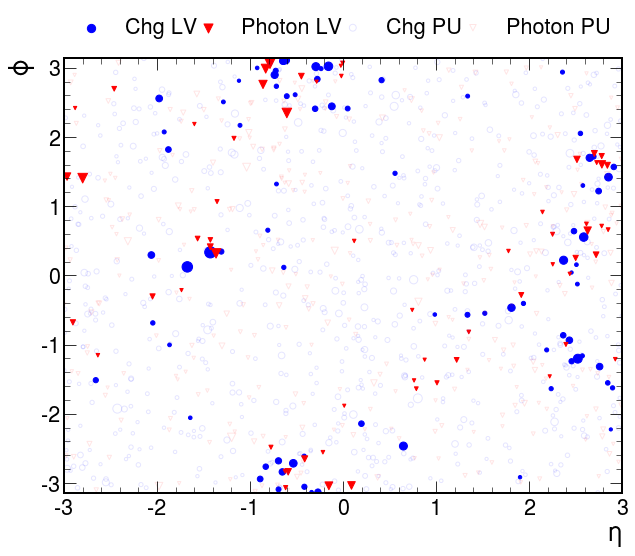

In [18]:
ievt = 0

# plot all PF Candidates
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(pfcands['PF/PF.Eta'][isChgLV][ievt],  pfcands['PF/PF.Phi'][isChgLV][ievt],  s=pfcands['PF/PF.PT'][isChgLV][ievt]*20.0,   c='blue',  marker='o', label='Chg LV')
ax.scatter(pfcands['PF/PF.Eta'][isNeuLV][ievt],  pfcands['PF/PF.Phi'][isNeuLV][ievt],  s=pfcands['PF/PF.PT'][isNeuLV][ievt]*20.0,   c='red',   marker='v', label='Photon LV')
ax.scatter(pfcands['PF/PF.Eta'][isChgPU][ievt],  pfcands['PF/PF.Phi'][isChgPU][ievt],  s=pfcands['PF/PF.PT'][isChgPU][ievt]*20.0,   
           marker='o', facecolor="None", edgecolor='blue', alpha=0.1, label='Chg PU')
ax.scatter(pfcands['PF/PF.Eta'][isNeuPU][ievt],  pfcands['PF/PF.Phi'][isNeuPU][ievt],  s=pfcands['PF/PF.PT'][isNeuPU][ievt]*20.0,   marker='v', facecolor="None",
         edgecolor='red', alpha=0.1,label='Photon PU')

ax.set_ylabel(r'$\phi$')
#plt.xticks(np.arange(-np.pi, np.pi))
ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel(r'$\eta$')
ax.set_xlim(-3.0, 3.0)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)
#plt.yticks(np.arange(-3.0, 3.0))
plt.show()

In [19]:
truth_chg = ak.flatten(1-pfcands['PF/PF.IsPU'][isChg])
puppi_chg = ak.flatten(pfcands['PF/PF.PuppiWeight'][isChg])
truth_neu = ak.flatten(1-pfcands['PF/PF.IsPU'][isNeu])
puppi_neu = ak.flatten(pfcands['PF/PF.PuppiWeight'][isNeu])

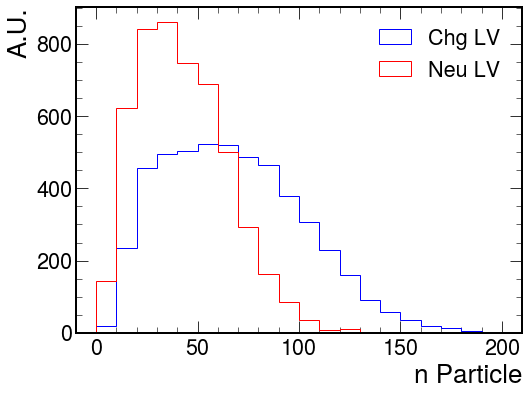

In [21]:
ak.sum(isChgLV,axis=1)
plt.figure(figsize=(8,6))
xmax=2e2
plt.hist(ak.sum(isChgLV,axis=1), histtype='step', bins=20, range=(0,xmax), color='blue', label='Chg LV')
#plt.hist(ak.sum(isChgPU,axis=1), histtype='step', bins=20, range=(0,xmax), color='blue', label='Chg PU')
plt.hist(ak.sum(isNeuLV,axis=1), histtype='step', bins=20, range=(0,xmax), color='red', label='Neu LV')
#plt.hist(ak.sum(isNeuPU,axis=1), histtype='step', bins=20, range=(0,xmax), color='red', label='Neu PU')
plt.xlabel(r'n Particle')
plt.ylabel('A.U.')
plt.legend()
plt.show()

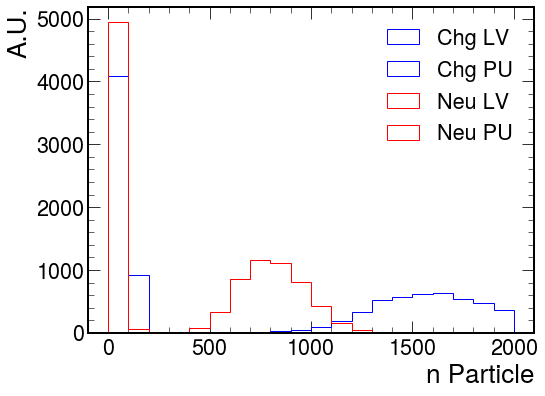

In [20]:
ak.sum(isChgLV,axis=1)
plt.figure(figsize=(8,6))
xmax=2e3
plt.hist(ak.sum(isChgLV,axis=1), histtype='step', bins=20, range=(0,xmax), color='blue', label='Chg LV')
plt.hist(ak.sum(isChgPU,axis=1), histtype='step', bins=20, range=(0,xmax), color='blue', label='Chg PU')
plt.hist(ak.sum(isNeuLV,axis=1), histtype='step', bins=20, range=(0,xmax), color='red', label='Neu LV')
plt.hist(ak.sum(isNeuPU,axis=1), histtype='step', bins=20, range=(0,xmax), color='red', label='Neu PU')
plt.xlabel(r'n Particle')
plt.ylabel('A.U.')
plt.legend()
plt.show()

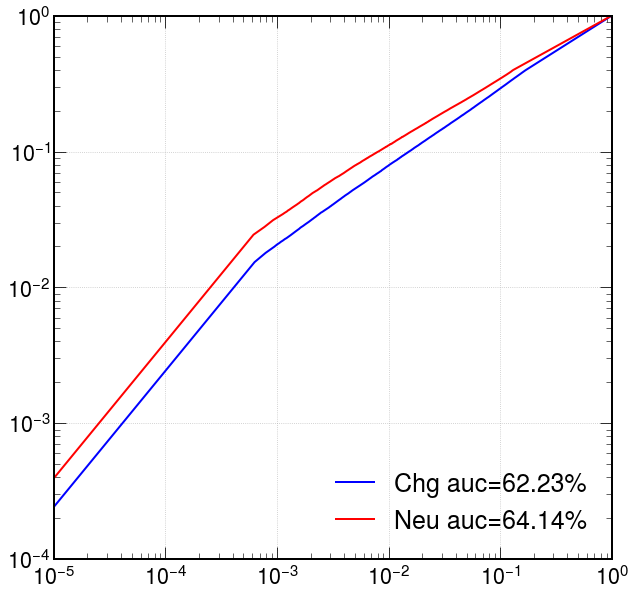

In [22]:
plt.figure()
fpr_chg, tpr_chg, thresholds_chg = roc_curve(truth_chg, puppi_chg)
auc = roc_auc_score(truth_chg, puppi_chg)
plt.plot(fpr_chg, tpr_chg, label="Chg auc=" + np.format_float_positional(auc * 100, precision=2) + "%",
                 linestyle='solid', linewidth=2, color='b')
fpr_neu, tpr_neu, thresholds_neu = roc_curve(truth_neu, puppi_neu)
auc = roc_auc_score(truth_neu, puppi_neu)
plt.plot(fpr_neu, tpr_neu, label= "Neu auc=" + np.format_float_positional(auc * 100, precision=2) + "%",
                 linestyle='solid', linewidth=2, color='r')
plt.xlim([1e-5, 1])
plt.xscale('log')
plt.ylim([1e-4, 1])
plt.yscale('log')
plt.legend(loc=4, fontsize=25)
plt.grid()
plt.show()

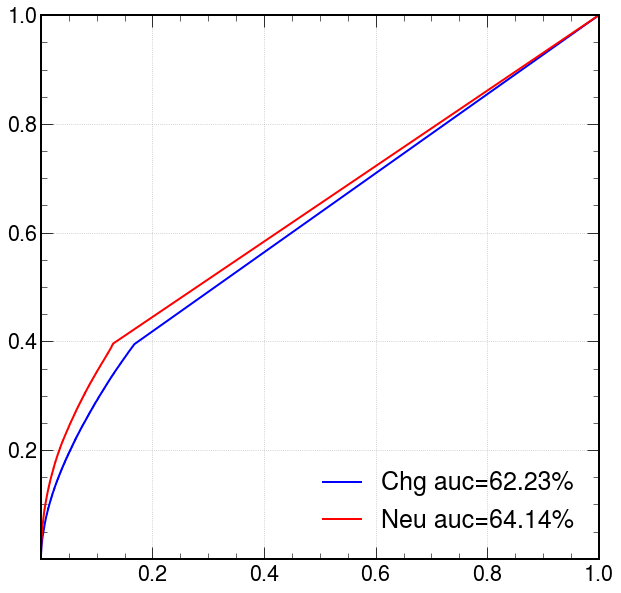

In [23]:
plt.figure()
fpr_chg, tpr_chg, thresholds_chg = roc_curve(truth_chg, puppi_chg)
auc = roc_auc_score(truth_chg, puppi_chg)
plt.plot(fpr_chg, tpr_chg, label="Chg auc=" + np.format_float_positional(auc * 100, precision=2) + "%",
                 linestyle='solid', linewidth=2, color='b')
fpr_neu, tpr_neu, thresholds_neu = roc_curve(truth_neu, puppi_neu)
auc = roc_auc_score(truth_neu, puppi_neu)
plt.plot(fpr_neu, tpr_neu, label= "Neu auc=" + np.format_float_positional(auc * 100, precision=2) + "%",
                 linestyle='solid', linewidth=2, color='r')
plt.xlim([1e-5, 1])
#plt.xscale('log')
plt.ylim([1e-4, 1])
#plt.yscale('log')
plt.legend(loc=4, fontsize=25)
plt.grid()
plt.show()